# Datatonic Data Project - Team Ginference - Engagement Inference for Trending Youtube Videos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pickle
import requests
import cv2
import nltk
import missingno
import emoji
import regex
import re
import time

from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.naive_bayes import MultinomialNB

from PIL import Image
from io import BytesIO
from collections import Counter
from gensim import corpora
from numpy import linalg as LA
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize

from prepare_features import *
%matplotlib inline
nltk.download('stopwords')
nltk.download('vader_lexicon')

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Loading and Preprocessing <a id="2"></a>

In [2]:
df_gb = pd.read_csv('../input/youtube-new/GBvideos.csv')
df_us = pd.read_csv('../input/youtube-new/USvideos.csv')

In [3]:
# concatenate GB and US dataframes
df = pd.concat([df_gb, df_us])
df = df.drop_duplicates(subset = ['video_id', 'trending_date'])

In [4]:
# transform dates to datetime forward
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

## Preprocessing and Aggregation

In [5]:
# get a snapshot of video lifetime over its trending period

df_aff = df.groupby(['video_id']).agg(
    # views TRending Starts
    views_trs = pd.NamedAgg(column = 'views', aggfunc = 'first'),
    
    # views TRending Ends
    views_tre = pd.NamedAgg(column = 'views', aggfunc = 'last'),
    
    # same for likes, dislikes and comments
    likes_trs = pd.NamedAgg(column = 'likes', aggfunc = 'first'),
    likes_tre = pd.NamedAgg(column = 'likes', aggfunc = 'last'),
    dislk_trs = pd.NamedAgg(column = 'dislikes', aggfunc = 'first'),
    dislk_tre = pd.NamedAgg(column = 'dislikes', aggfunc = 'last'),
    comms_trs = pd.NamedAgg(column = 'comment_count', aggfunc = 'first'),
    comms_tre = pd.NamedAgg(column = 'comment_count', aggfunc = 'last'),
    
    # date it gets on trending
    trending_start = pd.NamedAgg(column = 'trending_date', aggfunc = min),
    trending_end = pd.NamedAgg(column = 'trending_date', aggfunc = max),
    # integer value of number of days on trending
    days_trending = pd.NamedAgg(column = 'trending_date', aggfunc = lambda d: (max(d) - min(d)).days)
)

In [6]:
# engineered features
df_aff['views_gain'] = df_aff["views_tre"]-df_aff["views_trs"]
df_aff['likes_gain'] = df_aff["likes_tre"]-df_aff["likes_trs"]
df_aff['dislk_gain'] = df_aff["dislk_tre"]-df_aff["dislk_trs"]
df_aff['comms_gain'] = df_aff['comms_tre']-df_aff['comms_trs']

### Target Feature Definiton

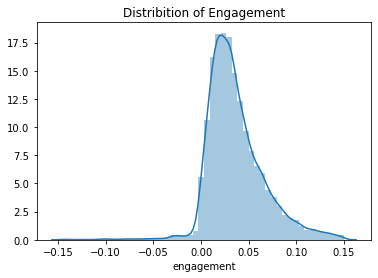

In [7]:
# engagement feature

df_aff['engagement'] = (10*df_aff['comms_gain'] + df_aff['likes_gain'])/df_aff['views_gain']
df_aff = df_aff[(df_aff['engagement'] > -1) & (df_aff['engagement'] < 1)]

sns.distplot(df_aff[(df_aff['engagement'] > -0.15) & (df_aff['engagement'] < 0.15)]['engagement']).set_title("Distribution of Engagement")
plt.show()

In [8]:
df_aff = df_aff.reset_index()

In [9]:
# pull additional columns into the new data set
df_all = df_aff.merge(df[['video_id','title', 'channel_title', 'category_id','publish_time', 'tags', 'description', 'thumbnail_link']], how = 'right', on = 'video_id')
df_all = df_all.drop_duplicates(subset = 'video_id')
df_all = df_all.dropna()

# Feature Engineering

Building a Pipeline to combine categorical, numeric features, with vectors extracted from text fields.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

#### Deriving new features using auxiliary functions

In [29]:
df_all['thumbnail_contrast'] = df_all['thumbnail_link'].apply(lambda x: thumbnail_contrast(x))
df_all = df_all[df_all['thumbnail_contrast'].notnull()]

In [30]:
def preprocess(df_all):
    out = pd.DataFrame(index = df_all.index)
    out['publish_to_trending'] = df_all['trending_start'] - df_all['publish_time']
    out['publish_to_trending'] = out['publish_to_trending'].apply(lambda x: x.days)
    out['publish_hour'] = df_all['publish_time'].apply(lambda x: x.hour)
    
    out['thumbnail_contrast'] = df_all['thumbnail_contrast']
    out['tags_letters_per_word'] = df_all['tags'].apply(process_tags).apply(letters_per_word)
    out['tags_num_words'] = df_all['tags'].apply(process_tags).apply(len)
    out['title_has_caps'] = df_all['title'].apply(remove_punctuation).apply(check_upper)
    out['title_caps_count'] = df_all['title'].apply(remove_punctuation).apply(count_caps)
    out['title_sentiment'] = df_all['title'].apply(get_sentiment)
    out['title_exclaimation_mark_count'] = df_all['title'].apply(count_exclaim)
    out['title_question_count'] = df_all['title'].apply(count_question)
    out['title_emoji_count'] = df_all['title'].apply(count_emoji)
    out['desc_url_count'] = df_all['description'].apply(desc_urls_count)
    out['desc_lines'] = df_all['description'].apply(desc_lines)
    out['desc_caps_count'] = df_all['description'].apply(lambda x: desc_upper(x))
    out['desc_len'] = df_all['description'].apply(lambda x: desc_len(x))
    out['desc_action_invite'] = df_all['description'].apply(lambda x: len(re.findall(r'\blike|comment|subscribe\b',x.lower())))
    return out


In [31]:
# columns used for feature engineering
fe_cols = ['trending_start', 'publish_time', 'thumbnail_contrast', 'tags', 'title', 'description']

In [32]:
out = preprocess(df_all)

In [33]:
out.head()

,publish_to_trending,publish_hour,thumbnail_contrast,tags_letters_per_word,tags_num_words,title_has_caps,title_caps_count,title_sentiment,title_exclaimation_mark_count,title_question_count,title_emoji_count,desc_url_count,desc_lines,desc_caps_count,desc_len,desc_action_invite
0,3317,17,83.325508,5.200000,5,0,0,0.5423,0,0,0,0,1,0,4,0
9,1,13,77.215584,5.112676,71,0,0,0.5719,0,0,0,0,1,0,12,0
15,1,7,79.438431,5.902439,41,0,0,-0.5994,0,0,0,10,27,11,201,3
18,0,18,82.283821,5.785714,14,1,9,0.3802,1,0,0,3,13,5,13,0
22,1,2,85.272774,4.750000,4,0,0,0.5267,0,0,0,0,4,3,38,0


#### One Hot Encoding category_id

In [34]:
ohe = OneHotEncoder(cols='category_id', drop_invariant=True)

#### Pipeline for transforming numerical features

In [35]:
features_transform = Pipeline([
    ('FE-Transformer', FunctionTransformer(preprocess, validate = False)),
    ('FE-std', StandardScaler())], verbose = True)

#### Transforming text and description into a vector of length 100

In [36]:
text_encoder = Pipeline([
    ('Text-TF-IDF', TfidfVectorizer(ngram_range=(1, 3))),
    ('Text-SVD', TruncatedSVD(n_components = 100))], verbose=True)

#### Using ColumnTransformer to combine all processing

In [37]:
transformer = ColumnTransformer([
    ('title-tr', text_encoder, 'title'),
    ('descr-tr', text_encoder, 'description'), 
    ('category', ohe, 'category_id'),
    ('num-features', features_transform, fe_cols)], verbose = True)

In [38]:
transformer

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('title-tr',
                                 Pipeline(memory=None,
                                          steps=[('Text-TF-IDF',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                                            

## Inference

Separating the target and performing the split of the dataset into train, test and validation.

In [120]:
y = df_all['engagement']
X = df_all.drop('engagement', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 10)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size = 0.5, random_state = 10)

Applying our transformations

In [121]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)
X_val = transformer.transform(X_val)

[Pipeline] ....... (step 1 of 2) Processing Text-TF-IDF, total=   0.5s
[Pipeline] .......... (step 2 of 2) Processing Text-SVD, total=   3.8s
[ColumnTransformer] ...... (1 of 4) Processing title-tr, total=   4.3s
[Pipeline] ....... (step 1 of 2) Processing Text-TF-IDF, total=   9.5s
[Pipeline] .......... (step 2 of 2) Processing Text-SVD, total=  57.4s
[ColumnTransformer] ...... (2 of 4) Processing descr-tr, total= 1.1min
[ColumnTransformer] ...... (3 of 4) Processing category, total=   0.0s
[Pipeline] .... (step 1 of 2) Processing FE-Transformer, total= 1.5min
[Pipeline] ............ (step 2 of 2) Processing FE-std, total=   0.0s
[ColumnTransformer] .. (4 of 4) Processing num-features, total= 1.5min


In [122]:
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

## MLP Regressor model

In [123]:
from sklearn.neural_network import MLPRegressor
mlpreg = MLPRegressor(hidden_layer_sizes=(3,), activation='relu',
         solver='adam', alpha=0.0001, batch_size='auto',
         learning_rate='adaptive', learning_rate_init=0.01,
         power_t=0.5, max_iter=5000, shuffle=True, random_state=9,
         tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
         nesterovs_momentum=True, early_stopping=False,
         validation_fraction=0.15, beta_1=0.5, beta_2=0.95,
         epsilon=1e-08)

mlpreg.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.5,
             beta_2=0.95, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(3,), learning_rate='adaptive',
             learning_rate_init=0.01, max_fun=15000, max_iter=5000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=9, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.15, verbose=False,
             warm_start=False)

In [124]:
y_pred = mlpreg.predict(X_test)

In [125]:
mean_absolute_error(y_test, y_pred)
# prints 0.02637048805882232

0.02637048805882232

## XGBoost with Bayesian Optimisation

Bayesian Optimisation isn't guaranteed to provide reproducible results, but it is suitable for quick hyperparameter tuning while iterating over models.

In [127]:
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from bayes_opt import BayesianOptimization

dmatrix_tr = xgb.DMatrix(X_train, label = y_train)
dmatrix_val = xgb.DMatrix(X_val, label = y_val)
dtest = xgb.DMatrix(X_test)

def xgb_func(max_depth, eta, subsample, colsample_bytree):
    params = {'eval_metric': 'mae',
            'max_depth': int(max_depth),
            'eta': eta,
            'subsample' : subsample,
            'colsample_bytree': colsample_bytree}
    cross_val = xgb.cv(params = params, 
                 dtrain = dmatrix_val, 
                 num_boost_round = 50,
                 nfold = 3)
    #Bayesian Optimization can only maximize, so define as -1 * error
    return -1.0*cross_val['test-mae-mean'].iloc[-1]

# Define the range of parameter values over which Bayesian Optimization should run
xgb_bo = BayesianOptimization(xgb_func, 
                              {'max_depth': (4,10),
                               'eta': (0.1, 0.4),
                               'subsample': (0.3, 1.0),
                               'colsample_bytree' :(0.3, 1.0)})

xgb_bo.maximize(init_points = 10, n_iter = 20, acq='ei')

|   iter    |  target   | colsam... |    eta    | max_depth | subsample |
-------------------------------------------------------------------------
|  1        | -0.03911  |  0.8364   |  0.188    |  4.748    |  0.5976   |
|  2        | -0.03942  |  0.9766   |  0.1665   |  8.105    |  0.5955   |
|  3        | -0.03669  |  0.7782   |  0.1794   |  6.936    |  0.8305   |
|  4        | -0.03617  |  0.9341   |  0.1169   |  9.401    |  0.7192   |
|  5        | -0.05404  |  0.8669   |  0.3759   |  7.854    |  0.3746   |
|  6        | -0.03962  |  0.55     |  0.2064   |  9.462    |  0.5183   |
|  7        | -0.05364  |  0.5627   |  0.3713   |  7.293    |  0.3689   |
|  8        | -0.03845  |  0.5415   |  0.1298   |  9.957    |  0.5358   |
|  9        | -0.04178  |  0.5953   |  0.1978   |  4.642    |  0.4856   |
|  10       | -0.0353   |  0.7962   |  0.2771   |  9.158    |  0.9699   |
|  11       | -0.03442  |  0.3749   |  0.1195   |  4.009    |  0.9989   |
|  12       | -0.03427  |  0.3375   | 

In [128]:
params = xgb_bo.max['params']
print(params)
params['max_depth'] = int(params['max_depth'])

#adding other parameters
params['objective'] = 'reg:linear'
params['silent'] = 1

{'colsample_bytree': 0.4396506235494122, 'eta': 0.1096410606876233, 'max_depth': 7.6321348130960125, 'subsample': 0.9994830800691745}


In [129]:
# defining the XGBoost model
model = xgb.train(params = params,
                  dtrain = dmatrix_tr,
                  num_boost_round = 200,
                  evals = [(dmatrix_val, 'val')], 
                  early_stopping_rounds=10)

[0]	val-rmse:0.41345
Will train until val-rmse hasn't improved in 10 rounds.
[1]	val-rmse:0.36900
[2]	val-rmse:0.32966
[3]	val-rmse:0.29450
[4]	val-rmse:0.26362
[5]	val-rmse:0.23602
[6]	val-rmse:0.21160
[7]	val-rmse:0.19027
[8]	val-rmse:0.17144
[9]	val-rmse:0.15486
[10]	val-rmse:0.14044
[11]	val-rmse:0.12772
[12]	val-rmse:0.11676
[13]	val-rmse:0.10709
[14]	val-rmse:0.09871
[15]	val-rmse:0.09145
[16]	val-rmse:0.08527
[17]	val-rmse:0.07991
[18]	val-rmse:0.07545
[19]	val-rmse:0.07187
[20]	val-rmse:0.06878
[21]	val-rmse:0.06623
[22]	val-rmse:0.06410
[23]	val-rmse:0.06238
[24]	val-rmse:0.06084
[25]	val-rmse:0.05977
[26]	val-rmse:0.05883
[27]	val-rmse:0.05805
[28]	val-rmse:0.05736
[29]	val-rmse:0.05680
[30]	val-rmse:0.05638
[31]	val-rmse:0.05608
[32]	val-rmse:0.05581
[33]	val-rmse:0.05563
[34]	val-rmse:0.05544
[35]	val-rmse:0.05527
[36]	val-rmse:0.05515
[37]	val-rmse:0.05522
[38]	val-rmse:0.05513
[39]	val-rmse:0.05512
[40]	val-rmse:0.05513
[41]	val-rmse:0.05505
[42]	val-rmse:0.05503
[43]	val

In [130]:
y_pred = model.predict(dtest)
mean_absolute_error(y_pred,y_test)
# prints 0.02481538307747204

0.02481538307747204

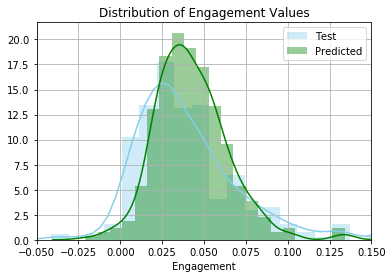

In [136]:
sns.distplot(y_test , color="skyblue", label="Test")
sns.distplot(y_pred , color="green", label="Predicted")
# sns.plt.legend()
plt.xlim([-0.05, 0.15])
plt.legend()
plt.grid()
plt.title('Distribution of Engagement Values')
plt.xlabel('Engagement')
plt.show()